In [1]:
import os
os.chdir('/home/hanwenli/work/2025/AL_SSL/hidden_state')

from utils import load_generated_result
import numpy as np
import math

In [2]:
result = load_generated_result('llama3', 'trivia_qa')

Reading file:  8aa76b7b-1009-4ac4-8d7f-fc2f73ce5030.npy


In [3]:
result[0]

{'montecarlosequenceentropy': 2.6767156451132905,
 'lexicalsimilarity': -0.19294532627865962,
 'semanticentropy': 2.834320496712656,
 'maximumsequenceprobability': 1.3573691844940186,
 'sar': -7.501996362145998,
 'align': 1.0,
 'inputs': '<|begin_of_text|><|start_header_id|>user<|end_header_id|>\nAnswer the question concisely. (less than 5 words)\nQ: "What fictional ship, with black hull and sails, was originally named ""Wicked Wench""?"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nA: ',
 'target_texts': ['wicked wench', 'black pearl'],
 'answer': 'The Black Pearl.'}

In [4]:
us_metrics = ['sar', 'maximumsequenceprobability', 'semanticentropy', 'lexicalsimilarity', 'montecarlosequenceentropy']
correctness = [data['align']>0.5 for data in result]
from sklearn.metrics import roc_auc_score
for metric in us_metrics:
    scores = []
    labels = []
    for data in result:
        value = data.get(metric)
        if value is not None and not math.isnan(value):
            scores.append(-value)
            labels.append(data['align'] > 0.5)
    if len(set(labels)) < 2:
        print(f'{metric} skipped: only one class present in y_true.')
    else:
        auroc = roc_auc_score(labels, scores)
        print(f'{metric} auroc: {auroc:.4f}')


sar auroc: 0.8683
maximumsequenceprobability auroc: 0.8328
semanticentropy auroc: 0.8372
lexicalsimilarity auroc: 0.8543
montecarlosequenceentropy auroc: 0.8327


In [5]:
def assign_labels_by_uncertainty(uncertainty_values, true_labels, high_threshold=0.4, low_threshold=0.4):
    """
    Assigns labels based on uncertainty values.
    - The top `high_threshold` proportion of uncertainty values are assigned True (1).
    - The bottom `low_threshold` proportion of uncertainty values are assigned False (0).
    
    Parameters:
        uncertainty_values (list or np.array): The uncertainty scores.
        true_labels (list or np.array): The ground truth labels.
        high_threshold (float): The proportion of highest uncertainty values to assign True.
        low_threshold (float): The proportion of lowest uncertainty values to assign False.
        
    Returns:
        assigned_labels (np.array): The assigned labels (-1 for unassigned).
        accuracy (float): The accuracy of assigned labels compared to true labels.
    """
    # Convert to numpy array
    uncertainty_values = np.array(uncertainty_values)
    true_labels = np.array(true_labels)

    # Determine threshold indices
    num_high = int(len(uncertainty_values) * high_threshold)
    num_low = int(len(uncertainty_values) * low_threshold)

    # Get sorted indices in ascending order
    sorted_indices = np.argsort(uncertainty_values)

    # Assign labels
    assigned_labels = np.full_like(true_labels, -1)  # Initialize with -1 (unassigned)
    assigned_labels[sorted_indices[:num_low]] = 0   # Lowest 40% assigned False (0)
    assigned_labels[sorted_indices[-num_high:]] = 1 # Highest 30% assigned True (1)

    # Compute accuracy (only on assigned labels)
    mask = assigned_labels != -1  # Consider only assigned labels
    accuracy = np.mean(assigned_labels[mask] == true_labels[mask])

    return assigned_labels, accuracy

In [6]:
labels = np.array([i['align']>0.5 for i in result])
uncertainty1 = np.array([-i['sar'] for i in result])
uncertainty2 = np.array([-i['sar'] for i in result])
# assign_labels_by_uncertainty_2(uncertainty1, uncertainty2, labels, high_threshold=0.05, low_threshold=0.05)
assign_labels_by_uncertainty(uncertainty2, labels, high_threshold=0.13, low_threshold=0.13)

(array([ True,  True, False, ...,  True,  True,  True]), 0.84925)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def plot_auroc(data):
    """
    Plot AUROC values from the provided model training data.
    
    Parameters:
    data (list): List of dictionaries containing model evaluation metrics including 'auroc'.
    
    Returns:
    None: Displays the plot.
    """
    # Extract AUROC values
    auroc_values = [entry['auroc'] for entry in data]
    
    # Create epoch numbers (assuming each entry represents one epoch)
    epochs = range(1, len(auroc_values) + 1)
    
    # Create the figure and axis
    plt.figure(figsize=(10, 6))
    
    # Plot AUROC values
    plt.plot(epochs, auroc_values, marker='o', linestyle='-', color='#1f77b4', 
             linewidth=2, markersize=6)
    
    # Add a trend line (smoothed curve)
    z = np.polyfit(epochs, auroc_values, 3)
    p = np.poly1d(z)
    plt.plot(epochs, p(epochs), linestyle='--', color='#ff7f0e', linewidth=2, 
             label='Trend')
    
    # Add labels and title
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('AUROC', fontsize=12)
    plt.title('AUROC Performance Over Epochs', fontsize=14)
    
    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Customize y-axis to start from a reasonable value (based on data)
    min_auroc = min(auroc_values)
    y_min = max(0, min_auroc - 0.05)  # Padding below minimum value
    plt.ylim(y_min, 1.0)  # AUROC is between 0 and 1
    
    # Add legend
    plt.legend()
    
    # Add a horizontal line at y=0.5 (random chance AUROC)
    plt.axhline(y=0.5, color='r', linestyle=':', label='Random Chance (0.5)')
    
    # Annotate final AUROC value
    final_auroc = auroc_values[-1]
    plt.annotate(f'Final AUROC: {final_auroc:.4f}', 
                 xy=(len(auroc_values), final_auroc),
                 xytext=(len(auroc_values) - 10, final_auroc + 0.05),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                 fontsize=10)
    
    # Show improvement from start to end
    improvement = auroc_values[-1] - auroc_values[0]
    plt.figtext(0.15, 0.02, f'Overall improvement: {improvement:.4f}', 
                fontsize=10, ha='left')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()
    
    # Print some statistics about the AUROC values
    print(f"Starting AUROC: {auroc_values[0]:.4f}")
    print(f"Final AUROC: {auroc_values[-1]:.4f}")
    print(f"Improvement: {improvement:.4f}")
    print(f"Best AUROC: {max(auroc_values):.4f} (Epoch {np.argmax(auroc_values) + 1})")

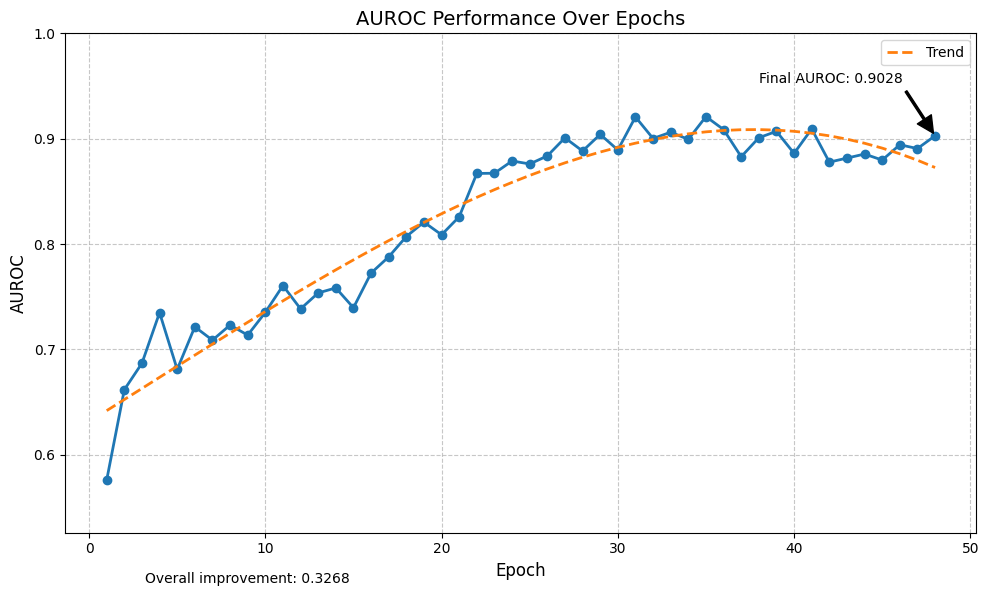

Starting AUROC: 0.5760
Final AUROC: 0.9028
Improvement: 0.3268
Best AUROC: 0.9210 (Epoch 35)


In [2]:
import pickle

with open('/home/hanwenli/work/2025/AL_SSL/results/Qwen2.5-14B-Instruct_trivia_qa.pkl', 'rb') as f:
    data = pickle.load(f)

plot_auroc(data)